# Impor Libraries

In [16]:
from modules.gnn import GNN
from modules.models import GraphSAGE, GCN
from modules.predictors import DotPredictor, MLPPredictor
import torch.nn.functional as F
from torch.optim import Adam
import itertools
import dgl
import torch
import matplotlib.pyplot as plt
from utils import plot_roc_curve, calculate_metrics, plot_training
from modules.graph import Graph
import numpy as np
import os

In [3]:
#FIXME: el edge (1,2) es equivalente a (2,1)), es importante asegurarse de que ambos casos se asignen al mismo conjunto (entrenamiento, validación o prueba). La implementación actual, sin embargo, no garantiza esto.
#FIXME: Entrenamiento con unicamente nodos, areglar varanza (long tail) y normalizar 
#FIXME: porq me esta dando la validacion eso, ver ambos lados como se infieren???

# Caso 1: 
    * Model :GraphSAGE
    * Features : Todos 
    * Predictor : DotProduct
    

In [2]:
# Crea archivos creacion dataset train, test, val -----------------------------------------------------
# Path de donde se guardaran archivos
path_dataset = os.getcwd() + "/datasets/DGL_Graph/MYCODEDiGraph/"  
graph = Graph(path_dataset, debug=True)

# 1.- Creo topologia dataset y label 
type = "DiGraph"  
file_path = "/home/vale/Desktop/GIT/TESIS/datasets/CAIDA_AS_Relationships/Serial_2/20220701.as-rel2.txt.bz2"  # Path archivos Relationships para creacion de topologia y etiquetado
graph.read_from_relationship_edgelist(file_path,type)
print("[TOPOLOGÍA]", graph.nx_graph)

# # 2.- Creo archivo nodes.csv con las features de los nodos que se van a aocupar y lo agrego a  dataset_dic de la clase
features_filename = "datasets/GNN_INTERNET_DATA/node_features.csv"
graph.features_nodes(features_filename)

# 3.- Eliminar nodos de grado 1 hojas

graph.remove_nodes_degree(1)
graph.remove_nodes_degree(1)
graph.remove_nodes_degree(1)

[TOPOLOGÍA] Graph with 74145 nodes and 461889 edges
Graph with 46720 nodes and 434464 edges
Graph with 46243 nodes and 433987 edges
Graph with 46235 nodes and 433979 edges


Done loading data from cached files.
None
Training edges: 87111
Validation edges: 172966
Test edges: 173902
In epoch 0, train loss: 0.9039171934127808, val loss: 0.9050289392471313
In epoch 10, train loss: 0.7075135111808777, val loss: 0.707729160785675
In epoch 20, train loss: 0.678613007068634, val loss: 0.6784592270851135
In epoch 30, train loss: 0.6257971525192261, val loss: 0.6249134540557861
In epoch 40, train loss: 0.5558063983917236, val loss: 0.5548447370529175
In epoch 50, train loss: 0.5034799575805664, val loss: 0.5029892921447754
In epoch 60, train loss: 0.4664180278778076, val loss: 0.4648422598838806
In epoch 70, train loss: 0.44186902046203613, val loss: 0.4406743049621582


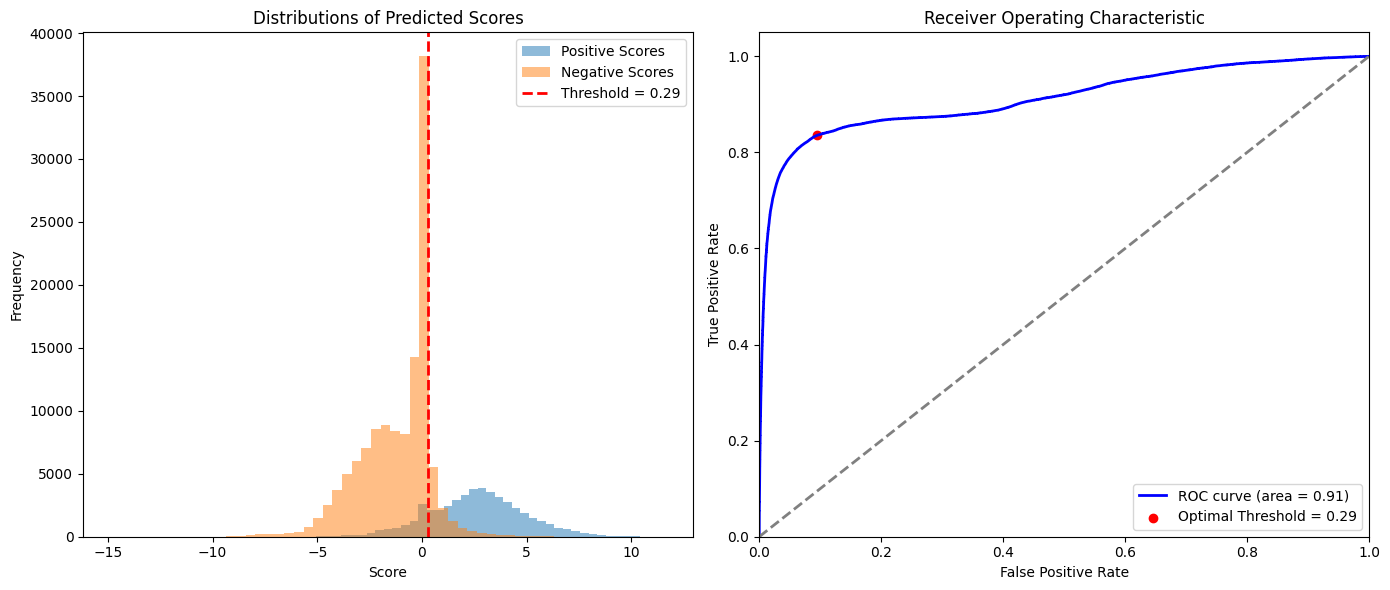

AUC: 0.9112833087656975
[LABEL] tensor([0., 0., 1.,  ..., 1., 1., 1.]) 87111
[ACC] [0. 0. 0. ... 0. 0. 0.] 87111
Correct predictions on training set:  0


In [27]:
data_path = "datasets/DGL_Graph/MYCODEDiGraph/"

gnn = GNN(debug=True)
gnn.load_dataset( data_path, force_reload=False)
gnn.split_dataset(0.2)
# gnn.split_dtaset_v2()

gnn.dgl_graph.ndata['feat'] = gnn.dgl_graph.ndata['feat'].float()

edge_label = gnn.dgl_graph.edata['Relationship']
train_mask = gnn.train_mask
test_mak = gnn.test_mask

in_feats = gnn.dgl_graph.ndata["feat"].size(1) #72
h_feats = 16
num_clases = 1
labels = gnn.dgl_graph.edata["Relationship"].float()
num_features_in =  gnn.dgl_graph.ndata["feat"].size(1)
num_feat_hidden = 15
num_feat_out = 1

# model = GraphSAGE(num_features_in, num_feat_hidden,num_feat_out)
model = GraphSAGE(num_features_in, num_feat_hidden, num_feat_out)
pred = DotPredictor()

# ----------- 3. set up loss and optimizer -------------- #

optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)

# ----------- 4. training -------------------------------- #

# Lista para almacenar los valores de pérdida
model_complexity = []

acc_val = []
acc_train = []

train_error = []
val_error = []

for e in range(80):
  # forward
  h = model(gnn.dgl_graph, gnn.dgl_graph.ndata['feat'])
  logits =  pred(gnn.dgl_graph, h)
  labels = gnn.dgl_graph.edata["Relationship"].float()

  # Calculo pérdida --------------------------------------------------------
  # Calcular la pérdida en el conjunto de entrenamiento --------------------
  train_loss = F.binary_cross_entropy_with_logits(logits[train_mask], labels[train_mask])
  train_error.append(train_loss.item())
  
  # Calcular la pérdida en el conjunto de validación -----------------------
  val_loss = F.binary_cross_entropy_with_logits(logits[gnn.val_mask], labels[gnn.val_mask])
  val_error.append(val_loss.item())


  # Calculo accuracy -------------------------------------------------------
  # Calcular la precisión en el conjunto de entrenamiento
  train_acc = logits[train_mask]

  # Calcular la precisión en el conjunto de validación
  val_acc = logits[gnn.val_mask] 

  # Guardar los valores de precisión
  acc_train.append(train_acc)
  acc_val.append(val_acc)

  # Guardar la complejidad (epochs) del modelo (aquí usamos el número de épocas)
  model_complexity.append(e + 1)

  # backward
  optimizer.zero_grad()
  train_loss.backward()
  optimizer.step()

  if e % 10 == 0:
      print('In epoch {}, train loss: {}, val loss: {}'.format(e, train_loss, val_loss))

# ----------- 5. Definir threashold -------------- #

true_train_labels = gnn.dgl_graph.edata["Relationship"][test_mak]
predicted_train_scores = logits.detach().numpy()[test_mak]
optimal_threshold = plot_roc_curve(true_train_labels,predicted_train_scores)


# ----------- 6. plot the loss and accuracy de training-------------- #

# TODO:Arregallr!!!!!!!!!
#FIXME: llevar esto a la funcipn
# Asegúrate de que cada tensor en la lista se desconecte de los gradientes y se convierta en numpy
acc_train = [(tensor > optimal_threshold).detach().numpy().astype(float) for tensor in acc_train]
acc_val = [(tensor > optimal_threshold).detach().numpy().astype(float) for tensor in acc_val]

# correct_predictions = (acc_train[0] == labels[train_mask]).sum()
print("[LABEL]", labels[train_mask], len(labels[train_mask]))
print("[ACC]", acc_train[0], len(acc_train[0]))
correct_predictions = np.sum(acc_train[10] == labels[train_mask])
print("Correct predictions on training set: ", correct_predictions)


# plot_training(train_error,acc_train,val_error,acc_val,model_complexity,optimal_threshold)




CALCULO
Classification Report:

              precision    recall  f1-score   support

           0     0.7350    0.6458    0.6875    125537
           1     0.2969    0.3911    0.3375     48003

    accuracy                         0.5754    173540
   macro avg     0.5159    0.5185    0.5125    173540
weighted avg     0.6138    0.5754    0.5907    173540



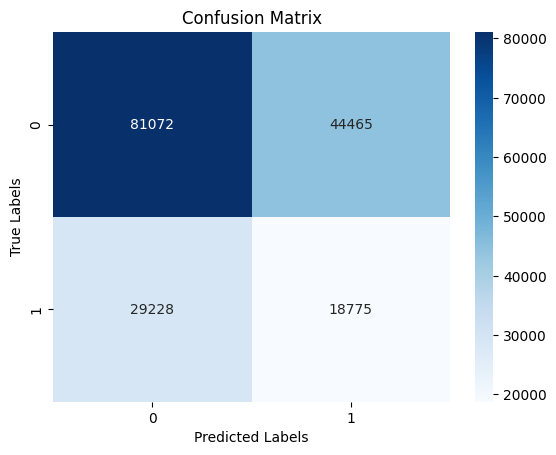

In [3]:
# ----------- 6. Calcular métricas -------------- #
calculate_metrics(predicted_scores,true_labels, threshold=optimal_threshold)

# Caso 2: 
    * Model :GraphSAGE
    * Features : ALL
    * Predictor : MLPPredictor
    

In [ ]:
# Crea archivos creacion dataset train, test, val -----------------------------------------------------

# Crea archivos creacion dataset train, test, val -----------------------------------------------------
# Path de donde se guardaran archivos
path_dataset = os.getcwd() + "/datasets/DGL_Graph/MYCODEDiGraph/"  
graph = Graph(path_dataset, debug=True)

# 1.- Creo topologia dataset y label 
type = "DiGraph"  
file_path = "/home/vale/Desktop/GIT/TESIS/datasets/CAIDA_AS_Relationships/Serial_2/20220701.as-rel2.txt.bz2"  # Path archivos Relationships para creacion de topologia y etiquetado
graph.read_from_relationship_edgelist(file_path,type)
print("[TOPOLOGÍA]", graph.nx_graph)

# # 2.- Creo archivo nodes.csv con las features de los nodos que se van a aocupar y lo agrego a  dataset_dic de la clase
features_filename = "datasets/GNN_INTERNET_DATA/node_features.csv"
graph.features_nodes(features_filename)

# 3.- Eliminar nodos de grado 1 hojas

graph.remove_nodes_degree(1)
graph.remove_nodes_degree(1)
graph.remove_nodes_degree(1)

In [2]:
# dataset con features de nodos unicamente degrees
data_path = "datasets/DGL_Graph/MYCODEDiGraph/"

gnn = GNN(debug=True)
gnn.load_dataset( data_path, force_reload=False)
gnn.split_dataset()

gnn.dgl_graph.ndata['feat'] = gnn.dgl_graph.ndata['feat'].float()

edge_label = gnn.dgl_graph.edata['Relationship']
train_mask = gnn.train_mask
test_mak = gnn.test_mask

in_feats = gnn.dgl_graph.ndata["feat"].size(1) #72
h_feats = 16
num_clases = 1

num_features_in =  gnn.dgl_graph.ndata["feat"].size(1)
num_feat_hidden = 16
num_feat_out = 1

# model = GraphSAGE(num_features_in, num_feat_hidden,num_feat_out)
model = GraphSAGE(num_features_in, num_feat_hidden, 8)
pred = MLPPredictor(8,1)

# ----------- 3. set up loss and optimizer -------------- #

optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)

# ----------- 4. training -------------------------------- #

# Lista para almacenar los valores de pérdida
loss_values = []

for e in range(80):
  # forward
  h = model(gnn.dgl_graph, gnn.dgl_graph.ndata['feat'])
  scores =  pred(gnn.dgl_graph, h)
  labels = gnn.dgl_graph.edata["Relationship"].float()

#   # print("[LABELS]",labels)
#   # print("[SCORES]",scores)


  # Calculo pérdida --------------------------------------------------------
  # Calcular la pérdida en el conjunto de entrenamiento --------------------
  # train_loss = F.binary_cross_entropy_with_logits(logits[train_mask], labels[train_mask])
  # train_error.append(train_loss.item())
  
  # # Calcular la pérdida en el conjunto de validación -----------------------
  # val_loss = F.binary_cross_entropy_with_logits(logits[gnn.val_mask], labels[gnn.val_mask])
  # val_error.append(val_loss.item())

  # # Guardar la complejidad (epochs) del modelo (aquí usamos el número de épocas)
  # model_complexity.append(e + 1)

  loss = F.binary_cross_entropy_with_logits(scores[train_mask], labels[train_mask])

  loss_values.append(loss.item())

  # backward
  optimizer.zero_grad()
  # train_loss.backward()
  loss.backward()
  optimizer.step()

  if e % 10 == 0:
    print('In epoch {}, loss: {}'.format(e, loss))
    # scores_numpy = numpyscores.numpy()

    # print(f'AUC {roc_auc_score(labels.detach().numpy(), scores.detach().numpy())}') #NO PODER DETACH!!!!!!!!!!!!!!
# print(f'AUC {roc_auc_score(labels.detach().numpy(), scores.detach().numpy())}')



# ----------- 5. plot the loss and accuracy -------------- #

plot_training(train_error,acc_train,val_error,acc_val,model_complexity)


# plt.plot(loss_values)
# plt.title('Pérdida del modelo')
# plt.ylabel('Pérdida')
# plt.xlabel('Época')
# plt.show()



Done loading data from cached files.
None
Training edges: 260387
Validation edges: 86941
Test edges: 86651
In epoch 0, loss: 0.740816056728363
In epoch 10, loss: 0.48931968212127686
In epoch 20, loss: 0.30748504400253296
In epoch 30, loss: 0.23477914929389954
In epoch 40, loss: 0.197828471660614
In epoch 50, loss: 0.16854892671108246
In epoch 60, loss: 0.1503080278635025
In epoch 70, loss: 0.13771188259124756


NameError: name 'train_error' is not defined

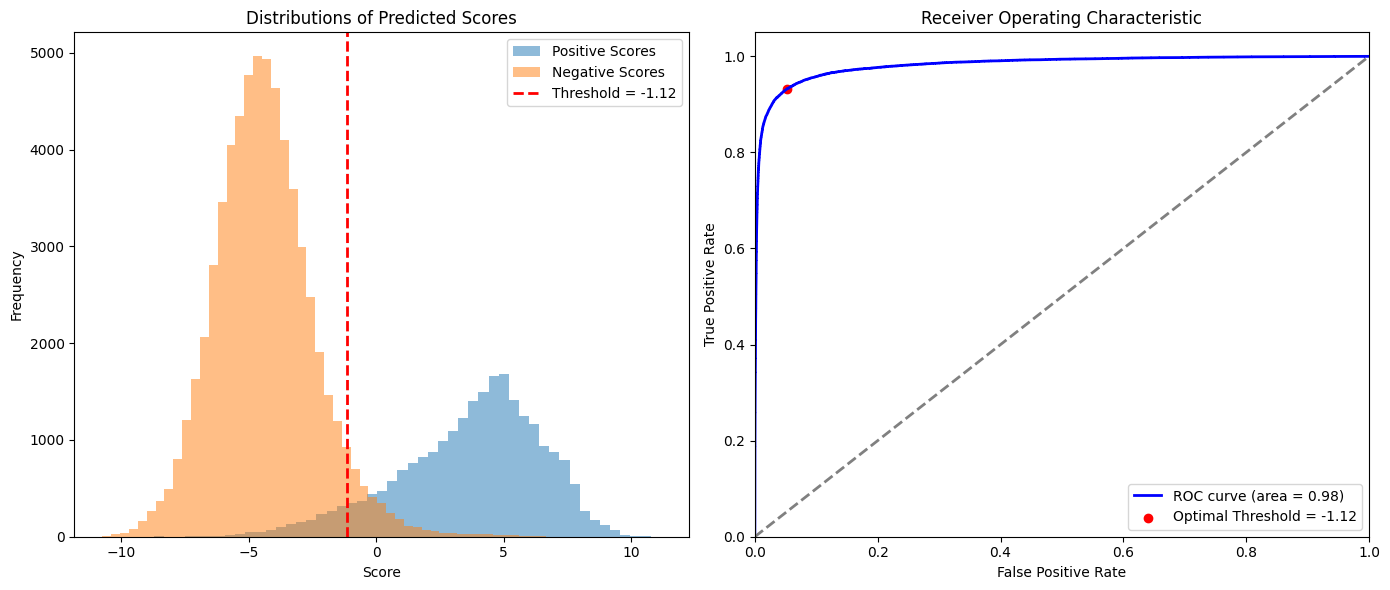

AUC: 0.9820875388990122
CALCULO
IF
ACCURACY 0.9432933353274813
PRESICION 0.872147533997133
RECALL 0.9325186412593206
F1 SCORE 0.9013232968308943
Classification Report:

              precision    recall  f1-score   support

           0     0.9733    0.9474    0.9602     62781
           1     0.8721    0.9325    0.9013     24140

    accuracy                         0.9433     86921
   macro avg     0.9227    0.9400    0.9308     86921
weighted avg     0.9452    0.9433    0.9439     86921



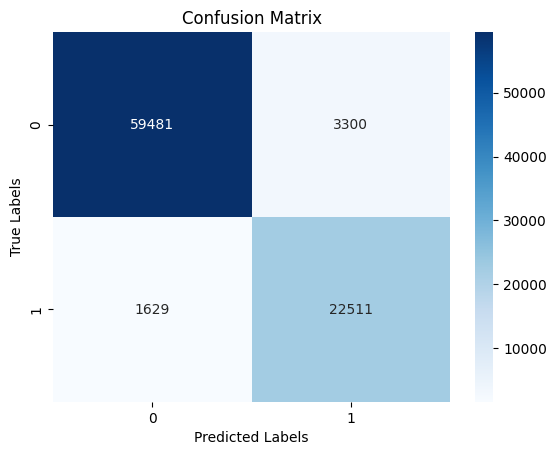

In [7]:
true_labels = gnn.dgl_graph.edata["Relationship"][test_mak]
predicted_scores = scores.detach().numpy()[test_mak]
optimal_threshold = plot_roc_curve(true_labels,predicted_scores)
cal_acc_pres_f1(predicted_scores,true_labels, threshold=optimal_threshold)

# Caso 3: 
    * Model :GraphSAGE
    * Features : in_degree y out_degree
    * Predictor : DotPredictor
    

In [5]:
# Crea archivos creacion dataset train, test, val -----------------------------------------------------
""" node_id,feat
 1,"10, 7"
 7843,"33, 54"

 """

path_dataset = os.getcwd() + "/datasets/DGL_Graph/MYCODEDiGraphDegree/"  
graph = Graph(path_dataset, debug=True)

# 1.- Creo topologia dataset y label 
type = "DiGraph"  
file_path = "datasets/CAIDA_AS_Relationships/Serial_2/20220701.as-rel2.txt.bz2"  # Path archivos Relationships para creacion de topologia y etiquetado
graph.read_from_relationship_edgelist(file_path,type)
print("[TOPOLOGÍA]", graph.nx_graph)

# # 2.- Creo archivo nodes.csv con las features de los nodos que se van a aocupar y lo agrego a  dataset_dic de la clase
features_filename = "datasets/GNN_INTERNET_DATA/node_features.csv"
graph.only_degree_features_nodes(features_filename)

graph.remove_nodes_degree(1)
graph.remove_nodes_degree(1)
graph.remove_nodes_degree(1)

[TOPOLOGÍA] Graph with 74145 nodes and 461889 edges


AttributeError: 'Graph' object has no attribute 'in_degree'

Done loading data from cached files.
None
Training edges: 260893
Validation edges: 86608
Test edges: 86478
tensor([[10.,  7.],
        [15.,  3.],
        [21.,  2.],
        ...,
        [ 2.,  0.],
        [ 2., 12.],
        [ 1.,  0.]])
In epoch 0, loss: 7387777.0
In epoch 10, loss: 264640.375
In epoch 20, loss: 413823.09375
In epoch 30, loss: 162022.796875
In epoch 40, loss: 74613.0078125
In epoch 50, loss: 53004.3984375
In epoch 60, loss: 34373.32421875
In epoch 70, loss: 22667.892578125
In epoch 80, loss: 17664.564453125
In epoch 90, loss: 14714.6552734375
In epoch 100, loss: 12291.5419921875
In epoch 110, loss: 10903.0673828125
In epoch 120, loss: 10061.708984375
In epoch 130, loss: 9340.041015625
In epoch 140, loss: 8579.8916015625
In epoch 150, loss: 7904.99462890625
In epoch 160, loss: 7347.748046875
In epoch 170, loss: 6686.19970703125
In epoch 180, loss: 6131.55859375
In epoch 190, loss: 5606.78466796875


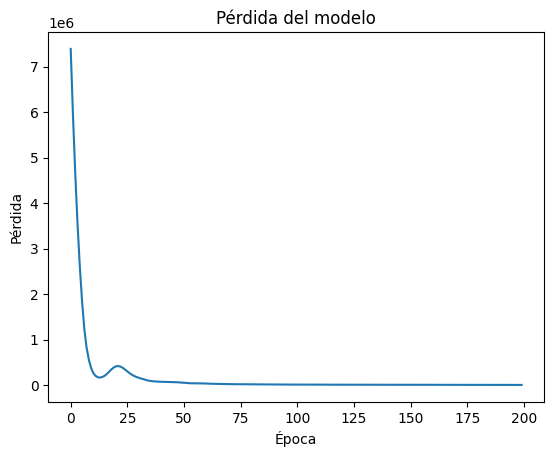

In [9]:
# dataset con features de nodos unicamente degrees
data_path = "datasets/DGL_Graph/MYCODEDiGraphDegree/"

gnn = GNN(debug=True)
gnn.load_dataset( data_path, force_reload=False)
gnn.split_dataset()

gnn.dgl_graph.ndata['feat'] = gnn.dgl_graph.ndata['feat'].float() #FIXME:
print(gnn.dgl_graph.ndata['feat'] )

edge_label = gnn.dgl_graph.edata['Relationship']
train_mask = gnn.train_mask
test_mak = gnn.test_mask

in_feats = gnn.dgl_graph.ndata["feat"].size(1) #72
h_feats = 16
num_clases = 1

num_features_in =  gnn.dgl_graph.ndata["feat"].size(1)
num_feat_hidden = 15
num_feat_out = 1

# model = GraphSAGE(num_features_in, num_feat_hidden,num_feat_out)
model = GraphSAGE(num_features_in, num_feat_hidden, num_feat_out)
pred = DotPredictor()

# ----------- 3. set up loss and optimizer -------------- #

optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)

# ----------- 4. training -------------------------------- #

# Lista para almacenar los valores de pérdida
loss_values = []

for e in range(200):
  # forward
  h = model(gnn.dgl_graph, gnn.dgl_graph.ndata['feat'])
  scores =  pred(gnn.dgl_graph, h)
  labels = gnn.dgl_graph.edata["Relationship"].float()

#   # print("[LABELS]",labels)
#   # print("[SCORES]",scores)
  loss = F.binary_cross_entropy_with_logits(scores[train_mask], labels[train_mask])

  loss_values.append(loss.item())

  # backward
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  if e % 10 == 0:
    print('In epoch {}, loss: {}'.format(e, loss))
    # scores_numpy = numpyscores.numpy()

    # print(f'AUC {roc_auc_score(labels.detach().numpy(), scores.detach().numpy())}') #NO PODER DETACH!!!!!!!!!!!!!!
# print(f'AUC {roc_auc_score(labels.detach().numpy(), scores.detach().numpy())}')

plt.plot(loss_values)
plt.title('Pérdida del modelo')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.show()



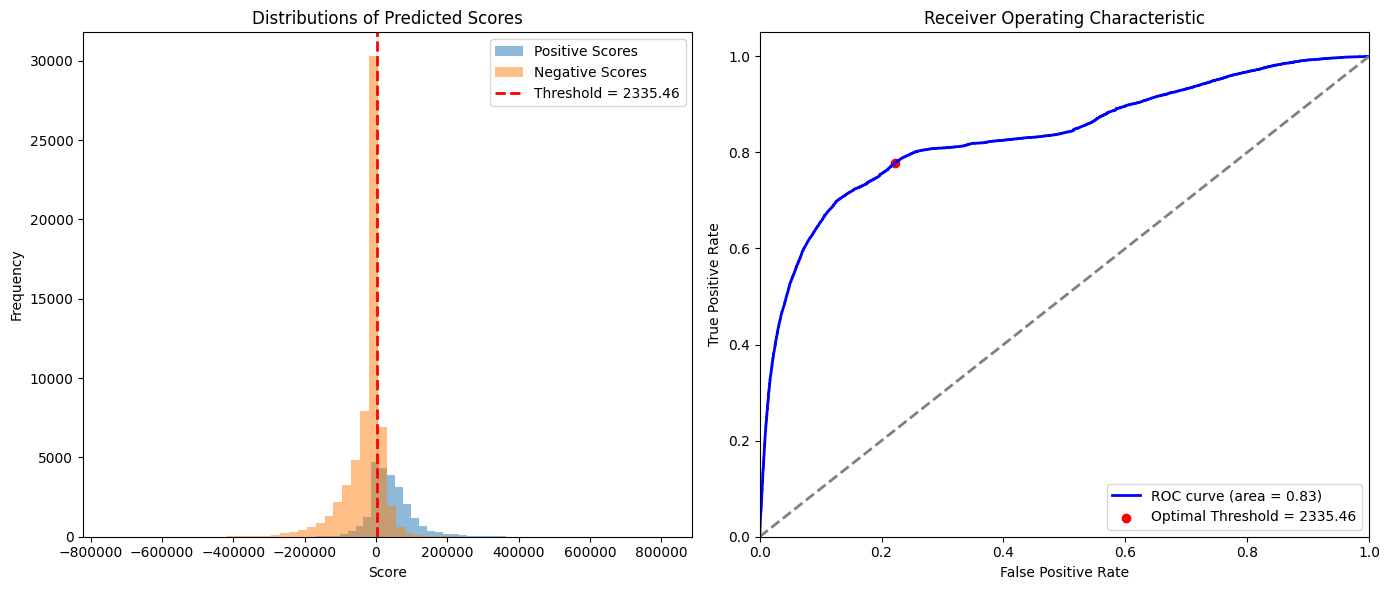

AUC: 0.8345524511778856
CALCULO
IF
ACCURACY 0.7781747959018479
PRESICION 0.5733115703242894
RECALL 0.7774807885065153
F1 SCORE 0.6599663210139147
Classification Report:

              precision    recall  f1-score   support

           0     0.9013    0.7784    0.8354     62534
           1     0.5733    0.7775    0.6600     23944

    accuracy                         0.7782     86478
   macro avg     0.7373    0.7780    0.7477     86478
weighted avg     0.8105    0.7782    0.7868     86478



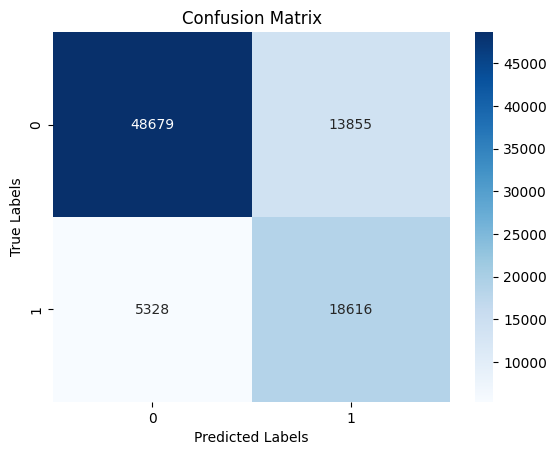

In [10]:
true_labels = gnn.dgl_graph.edata["Relationship"][test_mak]
predicted_scores = scores.detach().numpy()[test_mak]
optimal_threshold = plot_roc_curve(true_labels,predicted_scores)
cal_acc_pres_f1(predicted_scores,true_labels, threshold=optimal_threshold)

# Caso 4: 
    * Model :GraphSAGE
    * Features : ['AS_rank_continent','peeringDB_info_ratio','peeringDB_info_scope','peeringDB_info_type','peeringDB_policy_general' 'ASDB_C1L1', 'AS_rank_numberAsns', 'AS_rank_customer', 'AS_rank_peer', 'peeringDB_ix_count', 'peeringDB_fac_count', 'cti_top']
    * Predictor : MLPPredictor

In [6]:
# Crea archivos creacion dataset train, test, val -----------------------------------------------------

LIST_FEATURES_NO_CATEG = ['AS_rank_numberAsns', 'AS_rank_customer', 'peeringDB_fac_count', 'cti_top']

LIST_FEATURES_CATEG = ['AS_rank_continent',
                        # 'peeringDB_info_ratio',
                        # 'peeringDB_info_scope',
                        # 'peeringDB_info_type',
                        # 'peeringDB_policy_general'
                        'ASDB_C1L1'
                        ]

# Crear Di graph 
list_feat = LIST_FEATURES_NO_CATEG + LIST_FEATURES_CATEG
path_dataset = os.getcwd() +  "/datasets/DGL_Graph/MYCODEDiGraph/"  
graph = Graph(path_dataset, debug=True)

# 1.- Creo topologia dataset y label 
type = "DiGraph"  # o "MultiDiGraph"
file_path = "datasets/CAIDA_AS_Relationships/Serial_2/20220701.as-rel2.txt.bz2"  # Path archivos Relationships para creacion de topologia y etiquetado
graph.read_from_relationship_edgelist(file_path,type)
print("[TOPOLOGÍA]", graph.nx_graph)

# # 2.- Creo archivo nodes.csv con las features de los nodos que se van a aocupar y lo agrego a  dataset_dic de la clase
features_filename = "datasets/GNN_INTERNET_DATA/node_features.csv"
graph.features_nodes(features_filename,list_feat)

# 3.- Eliminar nodos de grado 1 hojas

graph.remove_nodes_degree(1)
graph.remove_nodes_degree(1)
graph.remove_nodes_degree(1)

[TOPOLOGÍA] Graph with 74145 nodes and 461889 edges
Graph with 46720 nodes and 434464 edges
Graph with 46243 nodes and 433987 edges
Graph with 46235 nodes and 433979 edges


Done loading data from cached files.
None
Training edges: 260751
Validation edges: 86305
Test edges: 86923
In epoch 0, loss: 0.8181799650192261
In epoch 10, loss: 0.5363751649856567
In epoch 20, loss: 0.40108534693717957
In epoch 30, loss: 0.2643354535102844
In epoch 40, loss: 0.20553115010261536
In epoch 50, loss: 0.18340057134628296
In epoch 60, loss: 0.1634751856327057
In epoch 70, loss: 0.15253299474716187
[tensor([0.5157, 0.3504, 0.4083,  ..., 0.1272, 0.2115, 0.1355],
       grad_fn=<IndexBackward0>), tensor([ 0.2008,  0.1162,  0.0211,  ..., -0.0132,  0.0251, -0.0930],
       grad_fn=<IndexBackward0>), tensor([-0.1398, -0.1284, -0.3008,  ..., -0.1766, -0.1526, -0.2849],
       grad_fn=<IndexBackward0>), tensor([-0.4681, -0.3920, -0.6584,  ..., -0.3627, -0.3769, -0.5570],
       grad_fn=<IndexBackward0>), tensor([-0.7944, -0.7417, -1.1006,  ..., -0.5899, -0.6447, -0.8881],
       grad_fn=<IndexBackward0>), tensor([-1.0770, -1.0142, -1.4528,  ..., -0.7657, -0.8336, -1.1268],
       

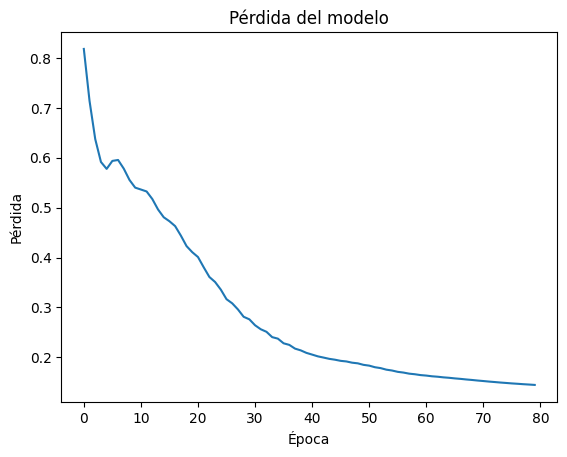

In [7]:
# dataset con features de nodos unicamente degrees
data_path = "datasets/DGL_Graph/MYCODEDiGraph/"

gnn = GNN(debug=True)
gnn.load_dataset( data_path, force_reload=False)
gnn.split_dataset(0.6)

gnn.dgl_graph.ndata['feat'] = gnn.dgl_graph.ndata['feat'].float()

edge_label = gnn.dgl_graph.edata['Relationship']
train_mask = gnn.train_mask
test_mak = gnn.test_mask

in_feats = gnn.dgl_graph.ndata["feat"].size(1) #72
h_feats = 16
num_clases = 1

num_features_in =  gnn.dgl_graph.ndata["feat"].size(1)
num_feat_hidden = 16
num_feat_out = 1

# model = GraphSAGE(num_features_in, num_feat_hidden,num_feat_out)
model = GraphSAGE(num_features_in, num_feat_hidden, 8)
pred = MLPPredictor(8,1)


# ----------- 3. set up loss and optimizer -------------- #

optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)

# ----------- 4. training -------------------------------- #

# Lista para almacenar los valores de pérdida
loss_values = []

val_values = []
train_values = []

for e in range(80):
  # forward
  h = model(gnn.dgl_graph, gnn.dgl_graph.ndata['feat'])
  scores =  pred(gnn.dgl_graph, h)
  labels = gnn.dgl_graph.edata["Relationship"].float()

  loss = F.binary_cross_entropy_with_logits(scores[train_mask], labels[train_mask])

  train_values.append(scores[train_mask])
  val_values.append(scores[gnn.val_mask])
  



  loss_values.append(loss.item())

  # backward
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  if e % 10 == 0:
    print('In epoch {}, loss: {}'.format(e, loss))

print(train_values)

plt.plot(loss_values)
plt.title('Pérdida del modelo')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.show()


# # Graficar Error en el conjunto de entrenamiento y validación
# plt.figure(figsize=(8, 6))
# plt.plot(model_complexity, train_error, label='Training Sample', color='cyan', linewidth=2)
# plt.plot(model_complexity, val_error, label='Test Sample', color='red', linewidth=2)
# plt.xlabel('Model Complexity')
# plt.ylabel('Prediction Error')
# plt.title('Overfitting')
# plt.legend()
# plt.grid(True)
# plt.show()


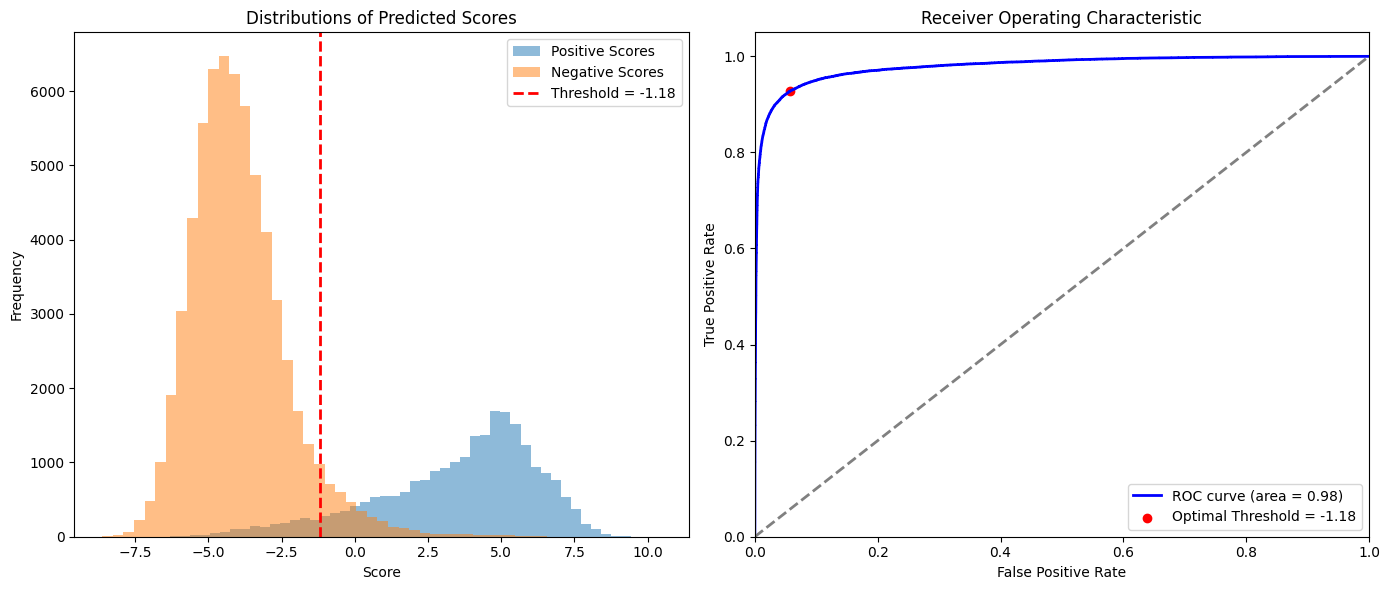

AUC: 0.9789254799090477
CALCULO
IF
ACCURACY 0.9386813616649218
PRESICION 0.8595999688691727
RECALL 0.927683520913825
F1 SCORE 0.8923449808119571
Classification Report:

              precision    recall  f1-score   support

           0     0.9719    0.9428    0.9571     63111
           1     0.8596    0.9277    0.8923     23812

    accuracy                         0.9387     86923
   macro avg     0.9157    0.9353    0.9247     86923
weighted avg     0.9411    0.9387    0.9394     86923



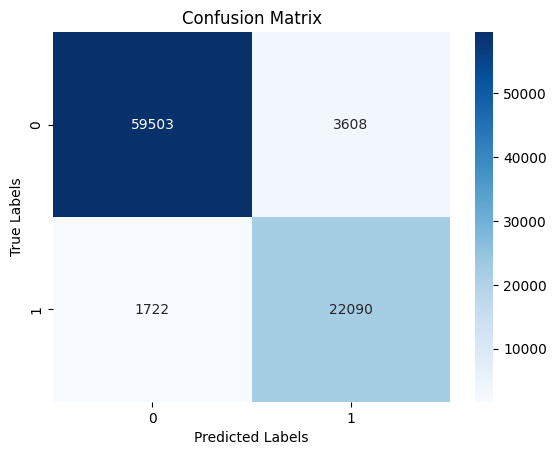

In [10]:
true_labels = gnn.dgl_graph.edata["Relationship"][test_mask]
predicted_scores = scores.detach().numpy()[test_mak]
optimal_threshold = plot_roc_curve(true_labels,predicted_scores)
cal_acc_pres_f1(predicted_scores,true_labels, threshold=optimal_threshold)

In [ ]:
predicted_scores = (predicted_scores > threshold).astype(int)



# Caso 5:
    * Model : ???
    * Features : ???
    * Predictor : ???
Se crea un grafo a partir de un collector de RIPE NCC y ver si este generaliza para otro grafos

In [ ]:
# Descargar grafo de BGPStream
#DEMORA HARTO

# df = download_graph_create_edges_csv("2022-06-01 00:00:00", "2022-06-01 00:15:00", ["rrc00"], "ribs", "graph-2022-06-rrc00-ribs", directed=False)
# print(df)

In [26]:
# Etiquetar grafo con CAIDA AS Relationships 
# Cargar el grafo desde el archivo .dgl


#Comprobando que se creo bien el grafo FIXME:
# import os
# import dgl
# import networkx as nx
# path = os.getcwd() + "/datasets/ROUTE_COLLECTORS/AS_GRAPH_NO_DIRIGIDO.dgl"
# graphs, _ = dgl.load_graphs(path)
# print(graphs)
# # [Graph(num_nodes=79957, num_edges=441580,
# #       ndata_schemes={}
# #       edata_schemes={})]


# path = "datasets/ROUTE_COLLECTORS/Downloads/graph-2022-06-rrc00-ribs-edges.csv"
# print(path)
# g = nx.read_edgelist(path, delimiter=',', nodetype=int, comments='src_id,dst_id')
# print(g)

[Graph(num_nodes=79957, num_edges=441580,
      ndata_schemes={}
      edata_schemes={})]


In [ ]:
list_feat = "all"


In [35]:
# Crear Archivos nodes.csv y edges.csv 

# Etiquetar edges.csv con CAIDA AS Relationships
file_csv = os.getcwd()+ "/datasets/ROUTE_COLLECTORS/Downloads/graph-2022-06-rrc00-ribs-edges.csv"
filename_caida = os.getcwd()+ "/datasets/CAIDA_AS_Relationships/Serial_2/20220701.as-rel2.txt.bz2"
graph = Graph(os.getcwd()+"/datasets/DGL_Graph/MYCODEGraphRRC00/", debug=True)
graph.label_edgelist(filename_caida,file_csv,type="DiGraph")

# Agregar atributos para cada AS
# 2.- Creo archivo nodes.csv con las features de los nodos que se van a aocupar y lo agrego a  dataset_dic de la clase
features_filename = "datasets/GNN_INTERNET_DATA/node_features.csv"
graph.features_nodes(features_filename,list_feat="all")

# 3.- Eliminar nodos de grado 1 hojas

graph.remove_nodes_degree(1)
graph.remove_nodes_degree(1)
graph.remove_nodes_degree(1)



[Tamaño df_edges_labeless: (220910, 3)]
Creando archivo edges.csv
[SAVE : /home/vale/Desktop/GIT/TESIS/datasets/DGL_Graph/MYCODEGraphRRC00/edges.csv]
DiGraph with 74145 nodes and 461889 edges
DiGraph with 46720 nodes and 434464 edges
DiGraph with 46243 nodes and 433987 edges
DiGraph with 46235 nodes and 433979 edges


Done saving data into cached files.
None
Training edges: 260288
Validation edges: 87038
Test edges: 86653
In epoch 0, loss: 0.7014463543891907
In epoch 10, loss: 0.577212929725647
In epoch 20, loss: 0.4938223361968994
In epoch 30, loss: 0.27211421728134155
In epoch 40, loss: 0.1847957968711853
In epoch 50, loss: 0.16132910549640656
In epoch 60, loss: 0.1483154445886612
In epoch 70, loss: 0.13856202363967896


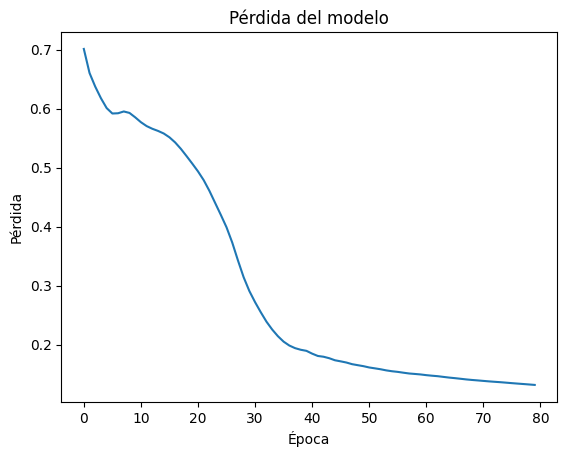

In [36]:
# dataset con features de nodos unicamente degrees
data_path = "datasets/DGL_Graph/MYCODEGraphRRC00/"

gnn = GNN(debug=True)
gnn.load_dataset( data_path, force_reload=False)
gnn.split_dataset()

gnn.dgl_graph.ndata['feat'] = gnn.dgl_graph.ndata['feat'].float()

edge_label = gnn.dgl_graph.edata['Relationship']
train_mask = gnn.train_mask
test_mak = gnn.test_mask

in_feats = gnn.dgl_graph.ndata["feat"].size(1) #72
h_feats = 16
num_clases = 1

num_features_in =  gnn.dgl_graph.ndata["feat"].size(1)
num_feat_hidden = 16
num_feat_out = 1

# model = GraphSAGE(num_features_in, num_feat_hidden,num_feat_out)
model = GraphSAGE(num_features_in, num_feat_hidden, 8)
pred = MLPPredictor(8,1)

# ----------- 3. set up loss and optimizer -------------- #

optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)

# ----------- 4. training -------------------------------- #

# Lista para almacenar los valores de pérdida
loss_values = []

for e in range(80):
  # forward
  h = model(gnn.dgl_graph, gnn.dgl_graph.ndata['feat'])
  scores =  pred(gnn.dgl_graph, h)
  labels = gnn.dgl_graph.edata["Relationship"].float()

#   # print("[LABELS]",labels)
#   # print("[SCORES]",scores)
  loss = F.binary_cross_entropy_with_logits(scores[train_mask], labels[train_mask])

  loss_values.append(loss.item())

  # backward
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  if e % 10 == 0:
    print('In epoch {}, loss: {}'.format(e, loss))
    # scores_numpy = numpyscores.numpy()

    # print(f'AUC {roc_auc_score(labels.detach().numpy(), scores.detach().numpy())}') #NO PODER DETACH!!!!!!!!!!!!!!
# print(f'AUC {roc_auc_score(labels.detach().numpy(), scores.detach().numpy())}')

plt.plot(loss_values)
plt.title('Pérdida del modelo')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.show()


In [ ]:
# TODO: Importar segundo dataset para el test

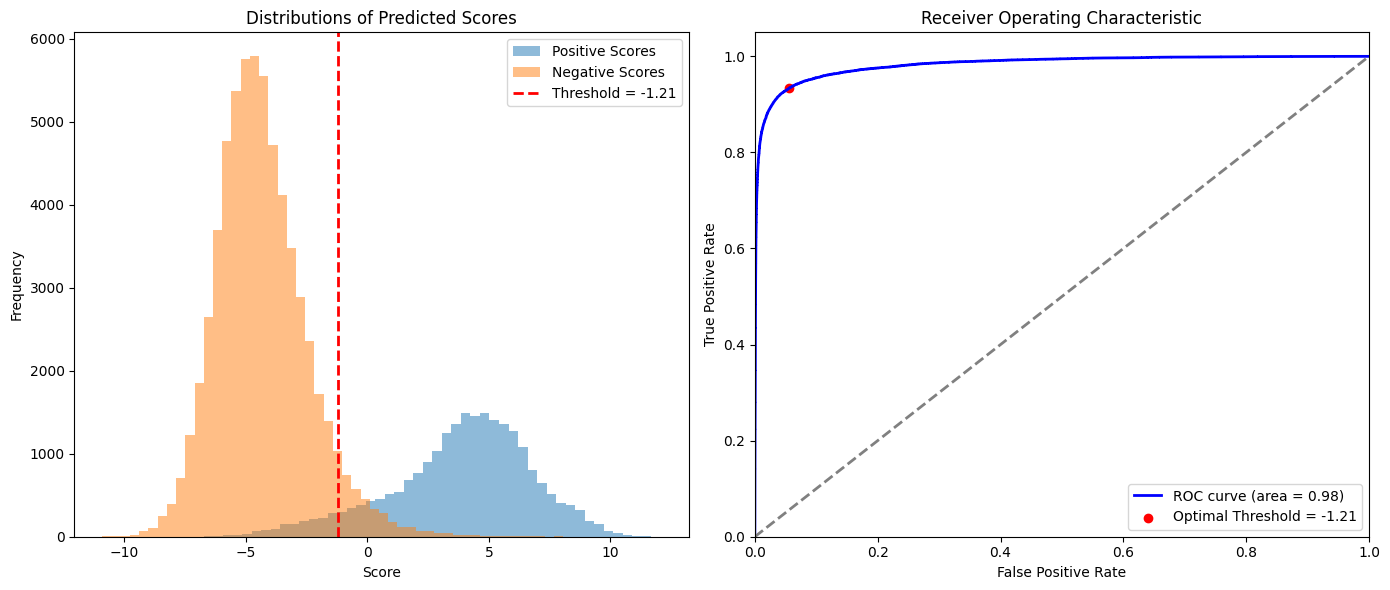

AUC: 0.9824871113939877
CALCULO
IF
ACCURACY 0.9413522901688344
PRESICION 0.8622981585017789
RECALL 0.9339402921871691
F1 SCORE 0.896690518783542
Classification Report:

              precision    recall  f1-score   support

           0     0.9745    0.9441    0.9591     63038
           1     0.8623    0.9339    0.8967     23615

    accuracy                         0.9414     86653
   macro avg     0.9184    0.9390    0.9279     86653
weighted avg     0.9439    0.9414    0.9421     86653



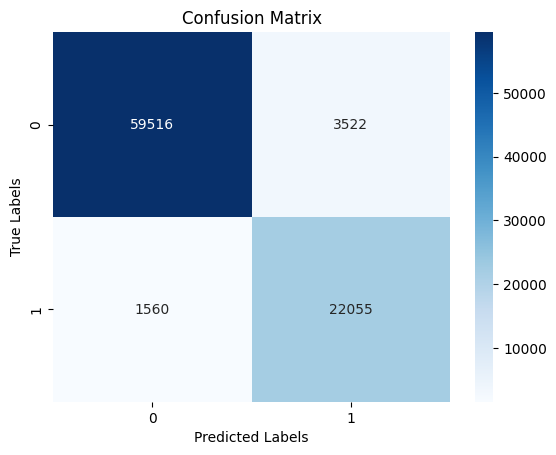

In [37]:
true_labels = gnn.dgl_graph.edata["Relationship"][test_mak]
predicted_scores = scores.detach().numpy()[test_mak]
optimal_threshold = plot_roc_curve(true_labels,predicted_scores)
cal_acc_pres_f1(predicted_scores,true_labels, threshold=optimal_threshold)